In [1]:
model_code = "pretrain_glove_no_dropout"
f_log_dir = "./"+model_code+"_log"
f_log_dir_train = "./"+model_code+"_log/training/"
f_log_dir_val = "./"+model_code+"_log/validate/"
f_chkpt_h5 = model_code+"_model"+".h5"
f_model_json = model_code+"_model_json"+".json"
f_model_weights = model_code+"_model_weights"+".h5"
f_infer_all = model_code+"_model_infer"+".txt"
f_model_png = model_code+"_model_image"+".png"

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from pythainlp.tokenize import word_tokenize
from gensim.models import KeyedVectors
from itertools import cycle
from scipy import interp
from collections import Counter
from pprint import pprint

import dill as pickle
import numpy as np
import pandas as pd
import io
import sys
import graphviz
import pydot

#matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

#keras
import keras.models
from keras.models import Sequential
from keras.layers import Dense, AveragePooling1D, Bidirectional
from keras.layers import LSTM, Convolution1D, Flatten, Dropout, Conv1D, GRU
from keras.layers import SpatialDropout1D, MaxPooling1D, TimeDistributed 
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard
from keras import losses
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import load_model

#sklearn
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn import svm, datasets

#more

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import tensorflow as tf

class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = f_log_dir_train #os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = f_log_dir_val #os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

In [4]:
# updatable plot
# a minimal example (sort of)
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()


In [5]:
# ทำ vector ของคำ

f = open('vectors.txt', encoding='utf-8')

vec = {}
f.seek(0)
f.readline()
for line in f:
    cols = line.rstrip().split(' ')
    w = cols[0]
    v = [float(x) for x in cols[1:]]
    vec[w] = np.array(v)
    len(vec)

In [6]:
glove_vocab = pd.read_csv('vocab.txt', header=None, sep= " ", encoding="UTF-8", names = ["Text", "Freq"])
glove_vocab.tail()

Text  Freq
234480                wwwthaipbsor     5
234481  wwwthaipbsorthNaReeKraJang     5
234482                           x     5
234483                        year     5
234484                         yes     5

In [7]:
glove_vocab = pd.DataFrame({'Text': glove_vocab['Text'],
                    'Key': glove_vocab.index})

glove_vocab.tail()

Key                        Text
234480  234480                wwwthaipbsor
234481  234481  wwwthaipbsorthNaReeKraJang
234482  234482                           x
234483  234483                        year
234484  234484                         yes

In [8]:
#create dataframe
thai2dict = {}
for word in vec:
    thai2dict[word] = vec[word]
glove = pd.DataFrame.from_dict(thai2dict,orient='index')
#thai2vec.head()
print(len(glove))
#thai2dict['เงิน']

234485


In [9]:
#Our Train/Test/Validate Data
data_text = pd.read_csv('SentiFine_deepcut_raw_text_only_copy.txt', header=None, encoding="UTF-8", names = ["Text"])
data_label = pd.read_csv('SentiFine_raw_label_only.txt', header=None, encoding="UTF-8", names = ["Sentiment"])
data_temp = pd.DataFrame({'text': data_text['Text'],
                    'sentiment': data_label['Sentiment']})

for index in range(len(data_temp)):
    sentence = data_temp['text'][index]
    data_temp['text'][index] = sentence.replace(" ", "")
                    
data_temp.head()
data_temp.describe()

sentiment                                      text
count       9352                                      9352
unique         3                                      7292
top     positive  ราคาทองคำแท่งซื้อบาทขายบาทเปลี่ยนแปลงบาท
freq        4349                                        80

In [10]:
# data_glove = []

# for index in range(len(data_temp)):
#     sentence = data_temp['text'][index]
#     data_glove.append(sentence_vectorizer(data_temp['text'][index],thai2vec_model,dim=300,use_mean=False))
                    
# print(len(data_glove))

In [11]:
#Decode Label from text to Int
temp_sentiment_int = []
for index in range(len(data_temp)):
    if data_label['Sentiment'][index] == 'neutral':
        temp_sentiment_int.append(0)
    elif data_label['Sentiment'][index] == 'negative':
        temp_sentiment_int.append(1)
    elif data_label['Sentiment'][index] == 'positive':
        temp_sentiment_int.append(2)        
    else:
        temp_sentiment_int.append("?")

In [12]:
data_prep = pd.DataFrame({'Text': data_text['Text'],
                     'Text1': data_temp['text'],
                    'Sentiment': data_label['Sentiment'],
                     'Sentiment_int': temp_sentiment_int
                    })
data_prep.tail()

Sentiment  Sentiment_int  \
9347  positive              2   
9348  positive              2   
9349  positive              2   
9350  positive              2   
9351  negative              1   

                                                   Text  \
9347  หุ้น ไทย เช้า นี้ ปิด บวก   อยู่ ที่   รับแรง ...   
9348  SET   เช้า ปิด ที่   +   มูลค่า การ ซื้อขาย   ...   
9349  ข้อมูล การ ผลิต แกร่ง   ส่ง หุ้น สหรัฐปิด บวก ...   
9350  ราคา ทองคำ แท่ง วัน อังคาร ที่   ก.ค.   ครั้ง ...   
9351  ราคา ทอง หลุดบาท ละบ.   ฉุด ผล ตอบแทน กองทองวู...   

                                                  Text1  
9347  หุ้นไทยเช้านี้ปิดบวกอยู่ที่รับแรงซื้อหุ้นขนาดใ...  
9348              SETเช้าปิดที่+มูลค่าการซื้อขายล้านบาท  
9349              ข้อมูลการผลิตแกร่งส่งหุ้นสหรัฐปิดบวก   
9350  ราคาทองคำแท่งวันอังคารที่ก.ค.ครั้งที่เวลาน.+ร้...  
9351            ราคาทองหลุดบาทละบ.ฉุดผลตอบแทนกองทองวูบ

In [13]:
my_dict_to_int = glove_vocab.set_index('Text')['Key'].to_dict()
int_to_mydict = glove_vocab.set_index('Key')['Text'].to_dict()

In [14]:
r = glove_vocab['Text']
all_text = ' '.join(str(r))
wo = all_text.split()
wo_counts = Counter(wo)
vocab = sorted(wo_counts, key=wo_counts.get, reverse=True)

In [15]:
print(my_dict_to_int['ไออุ่น'])
print(int_to_mydict[70395])

70395
ไออุ่น


In [16]:
#for index, row in data_prep.iterrows():

data_ints = []
i_count = 0
for index, row in data_prep.iterrows():
    temp_ints = []
    for word in row['Text'].split():
        #print(vocab_to_int[word])
        if my_dict_to_int.get(word, 0) != 0:
            temp_ints.append(my_dict_to_int[word])
    data_ints.append(temp_ints)
    i_count = i_count + 1

len(data_ints)

9352

In [17]:
data = pd.DataFrame({'Text': data_prep['Text'],
                         'Text1': data_prep['Text1'],
                     'Sentiment': data_prep['Sentiment'],
                     'Sentiment_int': data_prep['Sentiment_int'],
                          'Text_int': data_ints
                    })
data.tail()

Sentiment  Sentiment_int  \
9347  positive              2   
9348  positive              2   
9349  positive              2   
9350  positive              2   
9351  negative              1   

                                                   Text  \
9347  หุ้น ไทย เช้า นี้ ปิด บวก   อยู่ ที่   รับแรง ...   
9348  SET   เช้า ปิด ที่   +   มูลค่า การ ซื้อขาย   ...   
9349  ข้อมูล การ ผลิต แกร่ง   ส่ง หุ้น สหรัฐปิด บวก ...   
9350  ราคา ทองคำ แท่ง วัน อังคาร ที่   ก.ค.   ครั้ง ...   
9351  ราคา ทอง หลุดบาท ละบ.   ฉุด ผล ตอบแทน กองทองวู...   

                                                  Text1  \
9347  หุ้นไทยเช้านี้ปิดบวกอยู่ที่รับแรงซื้อหุ้นขนาดใ...   
9348              SETเช้าปิดที่+มูลค่าการซื้อขายล้านบาท   
9349              ข้อมูลการผลิตแกร่งส่งหุ้นสหรัฐปิดบวก    
9350  ราคาทองคำแท่งวันอังคารที่ก.ค.ครั้งที่เวลาน.+ร้...   
9351            ราคาทองหลุดบาทละบ.ฉุดผลตอบแทนกองทองวูบ    

                                               Text_int  
9347  [1013, 50, 1105, 24, 533, 1345, 33, 188429, 70...  
9348               [1105, 533, 1287, 2, 2145, 290, 406]  
9349                [78, 2, 303, 5301, 223, 1013, 1345]  
9350  [662, 1104, 2784, 25, 1421, 48, 87, 719, 455, ...  
9351                         [662, 455, 7604, 82, 2725]

In [18]:
embedding_dim = 50
embedding_matrix = np.zeros((234485, embedding_dim))

for index, row in glove_vocab.iterrows():
    #if index < 51556:
        #print(index)
        #print(row['Text'])
        try:
            embedding_vector = vec[str(row['Text'])]
            if embedding_vector is not None:
                word_current = str(row['Text'])
                embedding_matrix[my_dict_to_int[word_current]] = embedding_vector
        except KeyError:
            continue
        #print(embedding_vector)


In [19]:
#Define some static parameters of model

# Embedding
max_features = 20000
maxlen = 300
embedding_size = 128

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 30
epochs = 30

In [20]:
#Build Up X & Y for the Sequential Model

X = data['Text_int']
X = pad_sequences(X, maxlen = maxlen)

Y = pd.get_dummies(data['Sentiment'], columns=['negative','neural','positive']).values

#Split data to 2 parts: 1. XX&YY = train&test set  2. X_val&Y_val = validate set
XX, X_val, YY, Y_val = train_test_split(X,Y, test_size = 0.20, random_state = 42)

In [21]:
#Overall Data Summary 
print('No. of negative, neutral, positive in dataset:')
print(data[ data['Sentiment'] == 'negative'].size, data[ data['Sentiment'] == 'neutral'].size, data[ data['Sentiment'] == 'positive'].size)

print('Shape of XX&YY train&test data set:')
print(XX.shape,YY.shape)

print('Shape of X&Y validate data set:')
print(X_val.shape,Y_val.shape)

No. of negative, neutral, positive in dataset:
19055 5960 21745
Shape of XX&YY train&test data set:
(7481, 300) (7481, 3)
Shape of X&Y validate data set:
(1871, 300) (1871, 3)


In [22]:
print(glove.shape)

(234485, 50)


In [23]:
#del model

In [24]:
#Build model

model = Sequential()
model.add(Embedding(234485, 50, input_length=maxlen, weights=[embedding_matrix], trainable=True))
#model.add(Dropout(0.5))

model.add(Conv1D(64, kernel_size, activation='relu'))
model.add(MaxPooling1D(pool_size=pool_size))
#model.add(Dropout(0.5))

model.add(Conv1D(64, 1, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
#model.add(Dropout(0.5))

model.add(Bidirectional(GRU(32, return_sequences=True)))
#model.add(Dropout(0.5))
model.add(Bidirectional(GRU(16, return_sequences=True)))
#model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(16, activation='relu'))

#model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

optimizer = keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
model.compile(loss = 'categorical_crossentropy', optimizer=optimizer,metrics = ['accuracy'])

print(model.summary())
#plot_model(model, to_file=f_model_png)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 50)           11724250  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 296, 64)           16064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 74, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 74, 64)            4160      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 74, 64)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 74, 64)            18624     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 74, 32)            7776      
__________

In [25]:
# #Start training
# tensorBoardCallback = TensorBoard(log_dir=f_log_dir,histogram_freq=2,  write_graph=True)
# checkpointer = ModelCheckpoint(filepath=f_chkpt_h5, verbose=1, save_best_only=True)

In [26]:
#     #model.fit(train_x, train_y, epochs=15)
# history = model.fit(XX, YY, 
#               batch_size=batch_size, 
#               epochs=epochs,
#               shuffle=True, 
#               #callbacks=[checkpointer,tensorBoardCallback,plot_losses],
#               callbacks=[checkpointer,tensorBoardCallback,TrainValTensorBoard(write_graph=False)],
#               validation_data=(X_val, Y_val))

In [27]:
# print('MSE_AVG: ' + str(mse_avg) + ', MAE_AVG: ' + str(mae_avg))
# print("Accuracy: %.2f%%" % (mae_avg*100))

In [28]:
#Start training
#tensorBoardCallback = TensorBoard(log_dir=f_log_dir,histogram_freq=2,  write_graph=True)
checkpointer = ModelCheckpoint(filepath=f_chkpt_h5, verbose=1, save_best_only=True)

#No. of K-fold
k = 5
l = int(len(XX) / k)
#print(l)
mse_total, mae_total = 0, 0
for i in range(k):
    X_train = XX[i*l:(i+1)*l]
    Y_train = YY[i*l:(i+1)*l]

    X_test = np.concatenate([XX[:i*l], XX[(i+1)*l:]]);
    Y_test = np.concatenate([YY[:i*l], YY[(i+1)*l:]]);
    
    #print(X_train.shape, Y_train.shape)
    #print(X_test.shape, Y_test.shape)
    
    #model.fit(train_x, train_y, epochs=15)
    history = model.fit(X_train, Y_train, 
              batch_size=batch_size, 
              epochs=epochs,
              shuffle=True, 
              #callbacks=[checkpointer,tensorBoardCallback,plot_losses],
              callbacks=[checkpointer,TrainValTensorBoard(write_graph=False)],
              validation_data=(X_test, Y_test))

    #predictions = model.predict(test_x)
    #scores = model.evaluate(X_test, Y_test, verbose=0)
    #print("Accuracy: %.2f%%" % (scores[1]*100))
    mse, mae = model.evaluate(X_val, Y_val, verbose=1)
    mse_total += mse
    mae_total += mae

mse_avg = mse_total / k
mae_avg = mae_total / k
print('MSE_AVG: ' + str(mse_avg) + ', MAE_AVG: ' + str(mae_avg))
print("Accuracy: %.2f%%" % (mae_avg*100))

Train on 1496 samples, validate on 5985 samples
Epoch 1/30
1496/1496 [==============================] - 19s 13ms/step - loss: 0.9805 - acc: 0.4392 - val_loss: 0.9708 - val_acc: 0.4702

Epoch 00001: val_loss improved from inf to 0.97080, saving model to pretrain_glove_no_dropout_model.h5
Epoch 2/30
1496/1496 [==============================] - 13s 9ms/step - loss: 0.9037 - acc: 0.5174 - val_loss: 0.8794 - val_acc: 0.6025

Epoch 00002: val_loss improved from 0.97080 to 0.87936, saving model to pretrain_glove_no_dropout_model.h5
Epoch 3/30
1496/1496 [==============================] - 13s 9ms/step - loss: 0.7602 - acc: 0.6845 - val_loss: 0.7531 - val_acc: 0.6794

Epoch 00003: val_loss improved from 0.87936 to 0.75313, saving model to pretrain_glove_no_dropout_model.h5
Epoch 4/30
1496/1496 [==============================] - 13s 9ms/step - loss: 0.6137 - acc: 0.7473 - val_loss: 0.7408 - val_acc: 0.6650

Epoch 00004: val_loss improved from 0.75313 to 0.74084, saving model to pretrain_glove_no_

1496/1496 [==============================] - 13s 9ms/step - loss: 0.1326 - acc: 0.9432 - val_loss: 0.7557 - val_acc: 0.7825

Epoch 00012: val_loss did not improve from 0.51937
Epoch 13/30
1496/1496 [==============================] - 13s 9ms/step - loss: 0.1374 - acc: 0.9358 - val_loss: 0.8107 - val_acc: 0.7788

Epoch 00013: val_loss did not improve from 0.51937
Epoch 14/30
1496/1496 [==============================] - 13s 9ms/step - loss: 0.1160 - acc: 0.9512 - val_loss: 0.8141 - val_acc: 0.7724

Epoch 00014: val_loss did not improve from 0.51937
Epoch 15/30
1496/1496 [==============================] - 13s 9ms/step - loss: 0.1231 - acc: 0.9425 - val_loss: 0.8818 - val_acc: 0.7808

Epoch 00015: val_loss did not improve from 0.51937
Epoch 16/30
1496/1496 [==============================] - 13s 9ms/step - loss: 0.1691 - acc: 0.9265 - val_loss: 1.1151 - val_acc: 0.7068

Epoch 00016: val_loss did not improve from 0.51937
Epoch 17/30
1496/1496 [==============================] - 13s 9ms/step - 

1496/1496 [==============================] - 13s 9ms/step - loss: 0.1180 - acc: 0.9425 - val_loss: 0.7055 - val_acc: 0.8037

Epoch 00024: val_loss did not improve from 0.40127
Epoch 25/30
1496/1496 [==============================] - 13s 9ms/step - loss: 0.1247 - acc: 0.9439 - val_loss: 0.6924 - val_acc: 0.8018

Epoch 00025: val_loss did not improve from 0.40127
Epoch 26/30
1496/1496 [==============================] - 13s 9ms/step - loss: 0.1061 - acc: 0.9479 - val_loss: 0.7536 - val_acc: 0.7938

Epoch 00026: val_loss did not improve from 0.40127
Epoch 27/30
1496/1496 [==============================] - 13s 9ms/step - loss: 0.1103 - acc: 0.9418 - val_loss: 0.7652 - val_acc: 0.7963

Epoch 00027: val_loss did not improve from 0.40127
Epoch 28/30
1496/1496 [==============================] - 13s 9ms/step - loss: 0.1121 - acc: 0.9452 - val_loss: 0.8062 - val_acc: 0.7886

Epoch 00028: val_loss did not improve from 0.40127
Epoch 29/30
1496/1496 [==============================] - 13s 9ms/step - 

1496/1496 [==============================] - 13s 9ms/step - loss: 0.3297 - acc: 0.8529 - val_loss: 0.3063 - val_acc: 0.8718

Epoch 00004: val_loss did not improve from 0.30430
Epoch 5/30
1496/1496 [==============================] - 13s 9ms/step - loss: 0.2940 - acc: 0.8650 - val_loss: 0.3025 - val_acc: 0.8727

Epoch 00005: val_loss improved from 0.30430 to 0.30247, saving model to pretrain_glove_no_dropout_model.h5
Epoch 6/30
1496/1496 [==============================] - 13s 9ms/step - loss: 0.2438 - acc: 0.8877 - val_loss: 0.2858 - val_acc: 0.8769

Epoch 00006: val_loss improved from 0.30247 to 0.28578, saving model to pretrain_glove_no_dropout_model.h5
Epoch 7/30
1496/1496 [==============================] - 13s 9ms/step - loss: 0.2040 - acc: 0.9011 - val_loss: 0.3040 - val_acc: 0.8737

Epoch 00007: val_loss did not improve from 0.28578
Epoch 8/30
1496/1496 [==============================] - 13s 9ms/step - loss: 0.1785 - acc: 0.9151 - val_loss: 0.3430 - val_acc: 0.8683

Epoch 00008: va

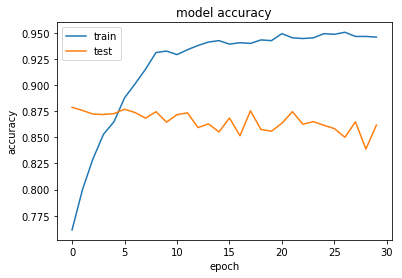

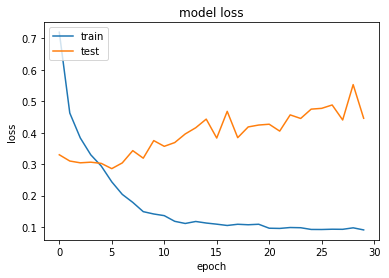

In [29]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
#Evaluation

y_true = []

yhat_class = model.predict_classes(X_val)
yhat = model.predict(X_val, verbose = 2, batch_size = batch_size)

for each in range(len(Y_val)):
    if (Y_val[each][0] == 1) & (Y_val[each][1] == 0) & (Y_val[each][2] == 0) : #negative
        y_true.append(0)
    elif (Y_val[each][0] == 0) & (Y_val[each][1] == 1) & (Y_val[each][2] == 0) : #neutral
        y_true.append(1)
    elif (Y_val[each][0] == 0) & (Y_val[each][1] == 0) & (Y_val[each][2] == 1) : #positive
        y_true.append(2)
    else:
        y_true.append(-1)

print(metrics.classification_report(y_true, yhat_class ,target_names = ["negative", "neutral","positive"]))

             precision    recall  f1-score   support

   negative       0.78      0.68      0.72       735
    neutral       0.68      0.65      0.67       260
   positive       0.73      0.81      0.77       876

avg / total       0.74      0.74      0.74      1871



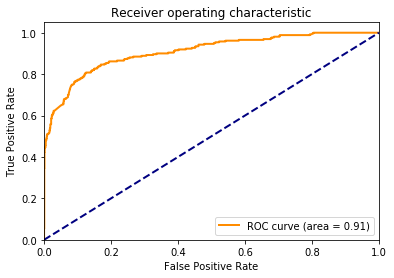

In [31]:
#ROC Curve based on Validation Set of data

#print(predictions.shape)
y_score = model.predict(X_val)
n_classes = Y_val.shape[1]
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_val[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_val.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#print(fpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Normalized confusion matrix
[[0.68027211 0.0462585  0.27346939]
 [0.1        0.65       0.25      ]
 [0.13584475 0.05022831 0.81392694]]


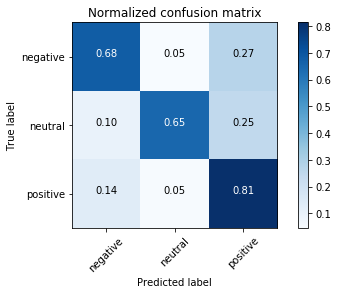

In [32]:
#Confusion Matrix

import itertools

score = ['negative', 'neutral','positive']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greys):
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(set(score)))
#     plt.xticks(tick_marks, score, rotation=45)
#     plt.yticks(tick_marks, score)
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
    
# Compute confusion matrix
# cm = confusion_matrix(Y_val[:,1], np.round(yhat[:,1]))
# np.set_printoptions(precision=3)
# plt.figure()
# plot_confusion_matrix(cm)    

# cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# plt.figure()
# plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

# plt.show()

yFit_class = np.argmax(y_score, axis=1)
yVal_class = np.argmax(Y_val, axis=1)

plot_confusion_matrix(confusion_matrix(yVal_class, yFit_class, labels=[0,1,2]), 
                      classes=['negative','neutral','positive'], 
                      normalize=True,
                      title='Normalized confusion matrix')


In [33]:
#load the best model
best_model = load_model(f_chkpt_h5)

# serialize model to JSON
model_json = best_model.to_json()
with open(f_model_json, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
best_model.save_weights(f_model_weights)

In [34]:
#load old model

with open(f_model_json) as ff:
    model_json=ff.read()
    extract_model=keras.models.model_from_json(model_json)
extract_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
extract_model.load_weights(f_model_weights)

yFit = extract_model.predict(X_val, batch_size=10, verbose=1)
yFit_class = model.predict_classes(X_val)

1871/1871 [==============================] - 6s 3ms/step


In [35]:
t = 0

if Y_val[t][0]==1: label_answer = "negative"
elif Y_val[t][1]==1: label_answer = "neutral"
else: label_answer = "positive"

if yFit_class[t]==0: predict_answer = "negative"
elif yFit_class[t]==1: predict_answer = "negative"
else: predict_answer = "negative"

temp_text = ''
for each in X_val[t]:
    if each != 0:
        temp_text=temp_text+(str(list(my_dict_to_int.keys())[list(my_dict_to_int.values()).index(each)]))

print('Text = '+temp_text+'\nLabel = '+label_answer+'\nPredict = '+predict_answer)

Text = ทองรูปพรรณขายออกบาทละบาท
Label = neutral
Predict = negative


In [36]:
t = 5

if Y_val[t][0]==1: label_answer = "negative"
elif Y_val[t][1]==1: label_answer = "neutral"
else: label_answer = "positive"

if yFit_class[t]==0: predict_answer = "negative"
elif yFit_class[t]==1: predict_answer = "negative"
else: predict_answer = "negative"

temp_text = ''
for each in X_val[t]:
    if each != 0:
        temp_text=temp_text+(str(list(my_dict_to_int.keys())[list(my_dict_to_int.values()).index(each)]))

print('Text = '+temp_text+'\nLabel = '+label_answer+'\nPredict = '+predict_answer)

Text = หุ้นสหรัฐปิดบวกจากแรงหนุนกลุ่มพลังงานเทคโนโลยี
Label = positive
Predict = negative


In [37]:
t = 2

if Y_val[t][0]==1: label_answer = "negative"
elif Y_val[t][1]==1: label_answer = "neutral"
else: label_answer = "positive"

if yFit_class[t]==0: predict_answer = "negative"
elif yFit_class[t]==1: predict_answer = "negative"
else: predict_answer = "negative"

temp_text = ''
for each in X_val[t]:
    if each != 0:
        temp_text=temp_text+(str(list(my_dict_to_int.keys())[list(my_dict_to_int.values()).index(each)]))

print('Text = '+temp_text+'\nLabel = '+label_answer+'\nPredict = '+predict_answer)

Text = ต่อยอดความฟินส่งแก๊งค์LINEโหนกระแสบอลโลก
Label = neutral
Predict = negative


In [38]:
t = 17

if Y_val[t][0]==1: label_answer = "negative"
elif Y_val[t][1]==1: label_answer = "neutral"
else: label_answer = "positive"

if yFit_class[t]==0: predict_answer = "negative"
elif yFit_class[t]==1: predict_answer = "negative"
else: predict_answer = "negative"

temp_text = ''
for each in X_val[t]:
    if each != 0:
        temp_text=temp_text+(str(list(my_dict_to_int.keys())[list(my_dict_to_int.values()).index(each)]))

print('Text = '+temp_text+'\nLabel = '+label_answer+'\nPredict = '+predict_answer)

Text = ปิดตลาดเช้าลบลบ
Label = negative
Predict = negative


In [39]:
scores = model.evaluate(X_val, Y_val, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1871/1871 [==============================] - 2s 951us/step
Accuracy: 73.86%


1871/1871 [==============================] - 2s 1ms/step


| Labels\Metrics   |   Precision |   Recall |   F-Score |   Support |
|:-----------------|------------:|---------:|----------:|----------:|
| negative         |    0.723514 | 0.761905 |  0.742213 |       735 |
| neutral          |    0.731602 | 0.65     |  0.688391 |       260 |
| positive         |    0.759815 | 0.751142 |  0.755454 |       876 |


Precision: 0.741634
Recall: 0.741315
F1-weight: 0.740933
F1-macro: 0.728686
F1-micro: 0.741315
Accuracy: 0.741315


Normalized confusion matrix
[[0.76190476 0.03673469 0.20136054]
 [0.11923077 0.65       0.23076923]
 [0.20890411 0.03995434 0.75114155]]




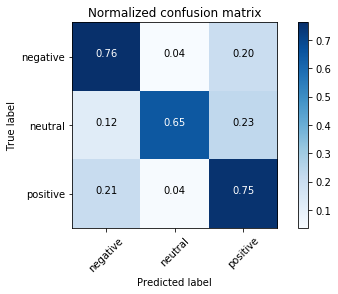

In [40]:
#sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

#more
from IPython.display import HTML, display
import tabulate
import itertools

yFit = best_model.predict(X_val, batch_size=batch_size, verbose=1)
yFit_class = np.argmax(yFit, axis=1)
yVal_class = np.argmax(Y_val, axis=1)

precision, recall, fscore, support = score(yVal_class, yFit_class, 
                                           average=None,labels = [0, 1, 2])

table = [['negative',precision[0],recall[0],fscore[0],support[0]],
['neutral',precision[1],recall[1],fscore[1],support[1]],
['positive',precision[2],recall[2],fscore[2],support[2]]]

#display(HTML(tabulate.tabulate(table, tablefmt='html', headers=['Labels\Metrics','Precision', 'Recall', 'F-Score', 'Support'])))
print("\n")
print(tabulate.tabulate(table, tablefmt='pipe', headers=['Labels\Metrics','Precision', 'Recall', 'F-Score', 'Support']))

print("\n")
w_precision = format(precision_score(yVal_class, yFit_class, average='weighted'),'.6f')
w_recall = format(recall_score(yVal_class, yFit_class, average='weighted'),'.6f')
w_fscore = format(f1_score(yVal_class, yFit_class, average='weighted'),'.6f')
ma_fscore = format(f1_score(yVal_class, yFit_class, average='macro'),'.6f')
mi_fscore = format(f1_score(yVal_class, yFit_class, average='micro'),'.6f')
w_accuracy = format(accuracy_score(yVal_class, yFit_class, normalize=True),'.6f')
#w_roc = format(roc_auc_score(yVal_class, yFit_class, average='weighted'),'.6f')
print("Precision: %s" % w_precision)
print("Recall: %s" % w_recall)
print("F1-weight: %s" % w_fscore)
print("F1-macro: %s" % ma_fscore)
print("F1-micro: %s" % mi_fscore)
print("Accuracy: %s" % w_accuracy)

print("\n")
#plt.figure()
plot_confusion_matrix(confusion_matrix(yVal_class, yFit_class, labels=[0,1,2]), 
                      classes=['negative','neutral','positive'], 
                      normalize=True,
                      title='Normalized confusion matrix')


print("\n")
display(HTML(tabulate.tabulate(table, tablefmt='latex', headers=['Labels\Metrics','Precision', 'Recall', 'F-Score', 'Support'])))


In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")